In [ ]:
!pip install streamlit==1.38.0
!pip install langchain-community==0.2.16
!pip install langgraph==0.2.14
!pip install fpdf==1.7.2
!pip install python-dotenv==1.0.1
!pip install langchain-google-genai

In [ ]:
# ------------------ Graph State Definition ------------------

class GraphState(TypedDict):
    preferences_text: str
    preferences: dict
    itinerary: str
    activity_suggestions: str
    useful_links: list[dict]
    weather_forecast: str
    packing_list: str
    food_culture_info: str
    chat_history: Annotated[list[dict], "List of question-response pairs"]
    user_question: str
    chat_response: str

In [ ]:
def generate_itinerary(state: GraphState):
    prompt = f"""
    Using the following preferences, create a detailed itinerary:
    {json.dumps(state['preferences'], indent=2)}

    Include sections for each day, dining options, and downtime.
    """
    result = llm.invoke(prompt).content
    return {"itinerary": result.strip()}

In [ ]:
def recommend_activities(state: GraphState):
    prompt = f"""
    Based on the following preferences and itinerary, suggest unique local activities:
    Preferences: {json.dumps(state['preferences'], indent=2)}
    Itinerary: {state['itinerary']}
    Provide suggestions in bullet points for each day if possible.
    """
    result = llm.invoke(prompt).content
    return {"activity_suggestions": result.strip()}

In [ ]:
def fetch_useful_links(state: GraphState):
    search = GoogleSerperAPIWrapper()
    destination = state['preferences'].get('destination', '')
    month = state['preferences'].get('month', '')
    query = f"Travel tips and guides for {destination} in {month}"
    try:
        search_results = search.results(query)
        organic_results = search_results.get("organic", [])
        links = [
            {"title": result.get("title", "No title"), "link": result.get("link", "")}
            for result in organic_results[:5]
        ]
        return {"useful_links": links}
    except Exception as e:
        return {"useful_links": [], "warning": f"Failed to fetch links: {str(e)}"}

In [ ]:
def weather_forecaster(state: GraphState):
    prompt = f"""
    Based on the destination and month, provide a detailed weather forecast including temperature, precipitation, and advice for travelers:
    Destination: {state['preferences'].get('destination', '')}
    Month: {state['preferences'].get('month', '')}
    """
    result = llm.invoke(prompt).content
    return {"weather_forecast": result.strip()}

In [ ]:
def packing_list_generator(state: GraphState):
    prompt = f"""
    Generate a comprehensive packing list for a {state['preferences'].get('holiday_type', 'general')} holiday in {state['preferences'].get('destination', '')} during {state['preferences'].get('month', '')} for {state['preferences'].get('duration', 0)} days.
    Include essentials based on expected weather and trip type.
    """
    result = llm.invoke(prompt).content
    return {"packing_list": result.strip()}

In [ ]:
def food_culture_recommender(state: GraphState):
    prompt = f"""
    For a trip to {state['preferences'].get('destination', '')} with a {state['preferences'].get('budget_type', 'mid-range')} budget:
    1. Suggest popular local dishes and recommended dining options.
    2. Provide important cultural norms, etiquette tips, and things travelers should be aware of.
    Format the response with clear sections for 'Food & Dining' and 'Culture & Etiquette'.
    """
    result = llm.invoke(prompt).content
    return {"food_culture_info": result.strip()}

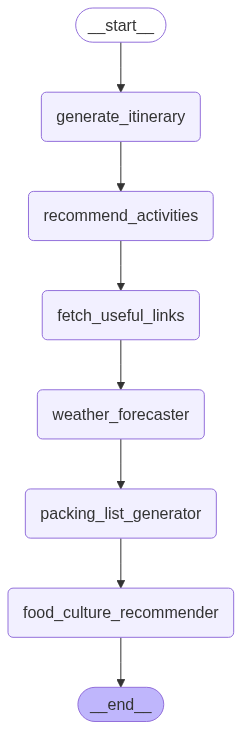

In [ ]:
# ------------------ Build LangGraph ------------------

workflow = StateGraph(GraphState)
workflow.add_node("generate_itinerary", generate_itinerary)
workflow.add_node("recommend_activities", recommend_activities)
workflow.add_node("fetch_useful_links", fetch_useful_links)
workflow.add_node("weather_forecaster", weather_forecaster)
workflow.add_node("packing_list_generator", packing_list_generator)
workflow.add_node("food_culture_recommender", food_culture_recommender)

workflow.set_entry_point("generate_itinerary")
workflow.add_edge("generate_itinerary", "recommend_activities")
workflow.add_edge("recommend_activities", "fetch_useful_links")
workflow.add_edge("fetch_useful_links", "weather_forecaster")
workflow.add_edge("weather_forecaster", "packing_list_generator")
workflow.add_edge("packing_list_generator", "food_culture_recommender")
workflow.add_edge("food_culture_recommender", END)

graph = workflow.compile()

# ------------------ Plot the Graph ------------------

Image(graph.get_graph().draw_mermaid_png())

In [ ]:
# ------------------ Run the Graph ------------------

# Sample user input
preferences = {
    "destination": "Lagos",
    "month": "December",
    "duration": 3,
    "num_people": "2",
    "holiday_type": "Romantic",
    "budget_type": "Luxury",
    "comments": "Include romantic dinners and scenic walks"
}

initial_state: GraphState = {
    "preferences_text": "\n".join([f"{k}: {v}" for k, v in preferences.items()]),
    "preferences": preferences,
    "itinerary": "",
    "activity_suggestions": "",
    "useful_links": [],
    "weather_forecast": "",
    "packing_list": "",
    "food_culture_info": "",
    "chat_history": [],
    "user_question": "",
    "chat_response": ""
}

print("🧭 Running graph...\n")
result = graph.invoke(initial_state)



# ------------------ Output ------------------

print("\n🗓️ Itinerary:\n", result["itinerary"])

In [ ]:
print("\n🎯 Activities:\n", result["activity_suggestions"])

In [ ]:
print("\n🌤️ Weather:\n", result["weather_forecast"])


In [ ]:
print("\n🎒 Packing List:\n", result["packing_list"])


In [ ]:
print("\n🍽️ Food & Culture:\n", result["food_culture_info"])


In [ ]:
print("\n🔗 Useful Links:")
for link in result["useful_links"]:
    print(f"- {link['title']}: {link['link']}")

In [ ]:
%%writefile app.py

import streamlit as st
import json
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
import json
from langchain_community.utilities import GoogleSerperAPIWrapper
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
import tempfile
from fpdf import FPDF

#Change your API to an envrionment variable
SERPER_API_KEY= os.environ.get("SERPER_API_KEY")
google_api_key = os.environ.get("GOOGLE_API_KEY")

# Initialize LLM
st.set_page_config(page_title="AI Travel Planner", layout="wide")
try:
    llm = ChatGoogleGenerativeAI(api_key=google_api_key, model='gemini-2.0-flash')
except Exception as e:
    st.error(f"LLM initialization failed: {str(e)}")
    st.stop()

# Initialize GoogleSerperAPIWrapper
try:
    search = GoogleSerperAPIWrapper()
except Exception as e:
    st.error(f"Serper API initialization failed: {str(e)}")
    st.stop()


# Export to PDF
def export_to_pdf(itinerary_text):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    try:
        for line in itinerary_text.split("\n"):
            line = line.encode('latin-1', 'replace').decode('latin-1')
            pdf.multi_cell(0, 10, line)
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf")
        pdf.output(temp_file.name)
        return temp_file.name
    except Exception as e:
        raise Exception(f"PDF generation failed: {str(e)}")


def chat_node(state):
    prompt = f"""
    Context:
    Preferences: {json.dumps(state['preferences'], indent=2)}
    Itinerary: {state['itinerary']}

    User Question:
    {state['user_question']}

    Respond conversationally with insights or suggestions : keep your response brief
    {{ "chat_response": "Your response here" }}
    """
    try:
        result = llm.invoke(prompt).content
        try:
            parsed = json.loads(result.strip())
            response = parsed.get("chat_response", result.strip())
        except json.JSONDecodeError:
            response = result.strip()
        chat_entry = {"question": state['user_question'], "response": response}
        chat_history = state.get('chat_history', []) + [chat_entry]
        return {"chat_response": response, "chat_history": chat_history}
    except Exception as e:
        return {"chat_response": "", "warning": str(e)}

def fetch_useful_links(state):
    search = GoogleSerperAPIWrapper()
    destination = state['preferences'].get('destination', '')
    month = state['preferences'].get('month', '')
    query = f"Travel tips and guides for {destination} in {month}"
    try:
        search_results = search.results(query)
        organic_results = search_results.get("organic", [])
        links = [
            {"title": result.get("title", "No title"), "link": result.get("link", "")}
            for result in organic_results[:5]
        ]
        return {"useful_links": links}
    except Exception as e:
        return {"useful_links": [], "warning": f"Failed to fetch links: {str(e)}"}


def food_culture_recommender(state):
    prompt = f"""
    For a trip to {state['preferences'].get('destination', '')} with a {state['preferences'].get('budget_type', 'mid-range')} budget:
    1. Suggest popular local dishes and recommended dining options.
    2. Provide important cultural norms, etiquette tips, and things travelers should be aware of.
    Format the response with clear sections for 'Food & Dining' and 'Culture & Etiquette'.
    """
    try:
        result = llm.invoke(prompt).content
        return {"food_culture_info": result.strip()}
    except Exception as e:
        return {"food_culture_info": "", "warning": str(e)}


def generate_itinerary(state):

    prompt = f"""
    Using the following preferences, create a detailed itinerary:
    {json.dumps(state['preferences'], indent=2)}

    Include sections for each day, dining options, and downtime.
    """
    try:
        result = llm.invoke(prompt).content
        return {"itinerary": result.strip()}
    except Exception as e:
        return {"itinerary": "", "warning": str(e)}

def packing_list_generator(state):
    prompt = f"""
    Generate a comprehensive packing list for a {state['preferences'].get('holiday_type', 'general')} holiday in {state['preferences'].get('destination', '')} during {state['preferences'].get('month', '')} for {state['preferences'].get('duration', 0)} days.
    Include essentials based on expected weather and trip type.
    """
    try:
        result = llm.invoke(prompt).content
        return {"packing_list": result.strip()}
    except Exception as e:
        return {"packing_list": "", "warning": str(e)}

def recommend_activities(state):
    prompt = f"""
    Based on the following preferences and itinerary, suggest unique local activities:
    Preferences: {json.dumps(state['preferences'], indent=2)}
    Itinerary: {state['itinerary']}

    Provide suggestions in bullet points for each day if possible.
    """
    try:
        result = llm.invoke(prompt).content
        return {"activity_suggestions": result.strip()}
    except Exception as e:
        return {"activity_suggestions": "", "warning": str(e)}

def weather_forecaster(state):

    prompt = f"""
    Based on the destination and month, provide a detailed weather forecast including temperature, precipitation, and advice for travelers:
    Destination: {state['preferences'].get('destination', '')}
    Month: {state['preferences'].get('month', '')}
    """
    try:
        result = llm.invoke(prompt).content
        return {"weather_forecast": result.strip()}
    except Exception as e:
        return {"weather_forecast": "", "warning": str(e)}


# Define state
class GraphState(TypedDict):
    preferences_text: str
    preferences: dict
    itinerary: str
    activity_suggestions: str
    useful_links: list[dict]
    weather_forecast: str
    packing_list: str
    food_culture_info: str
    chat_history: Annotated[list[dict], "List of question-response pairs"]
    user_question: str
    chat_response: str

# ------------------- LangGraph -------------------

workflow = StateGraph(GraphState)
workflow.add_node("generate_itinerary", generate_itinerary)
# workflow.add_node("fetch_useful_links", fetch_useful_links)
# workflow.add_node("weather_forecaster", weather_forecaster)
# workflow.add_node("recommend_activities", recommend_activities)
# workflow.add_node("packing_list_generator", packing_list_generator)
# workflow.add_node("food_culture_recommender", food_culture_recommender)
# workflow.add_node("chat", chat_node)
workflow.set_entry_point("generate_itinerary")
workflow.add_edge("generate_itinerary", END)
# workflow.add_edge("recommend_activities", END)
# workflow.add_edge("fetch_useful_links", END)
# workflow.add_edge("weather_forecaster", END)
# workflow.add_edge("packing_list_generator", END)
# workflow.add_edge("food_culture_recommender", END)
# workflow.add_edge("chat", END)
graph = workflow.compile()

# ------------------- UI -------------------

st.markdown("# AI-Powered Travel Itinerary Planner")

if "state" not in st.session_state:
    st.session_state.state = {
        "preferences_text": "",
        "preferences": {},
        "itinerary": "",
        "activity_suggestions": "",
        "useful_links": [],
        "weather_forecast": "",
        "packing_list": "",
        "food_culture_info": "",
        "chat_history": [],
        "user_question": "",
        "chat_response": ""
    }

with st.form("travel_form"):
    col1, col2 = st.columns(2)
    with col1:
        destination = st.text_input("Destination")
        month = st.selectbox("Month of Travel", ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
        duration = st.slider("Number of Days", 1, 30, 7)
        num_people = st.selectbox("Number of People", ["1", "2", "3", "4-6", "7-10", "10+"])
    with col2:
        holiday_type = st.selectbox("Holiday Type", ["Any", "Party", "Skiing", "Backpacking", "Family", "Beach", "Festival", "Adventure", "City Break", "Romantic", "Cruise"])
        budget_type = st.selectbox("Budget Type", ["Budget", "Mid-Range", "Luxury", "Backpacker", "Family"])
        comments = st.text_area("Additional Comments")
    submit_btn = st.form_submit_button("Generate Itinerary")

if submit_btn:
    preferences_text = f"Destination: {destination}\nMonth: {month}\nDuration: {duration} days\nPeople: {num_people}\nType: {holiday_type}\nBudget: {budget_type}\nComments: {comments}"
    preferences = {
        "destination": destination,
        "month": month,
        "duration": duration,
        "num_people": num_people,
        "holiday_type": holiday_type,
        "budget_type": budget_type,
        "comments": comments
    }
    st.session_state.state.update({
        "preferences_text": preferences_text,
        "preferences": preferences,
        "chat_history": [],
        "user_question": "",
        "chat_response": "",
        "activity_suggestions": "",
        "useful_links": [],
        "weather_forecast": "",
        "packing_list": "",
        "food_culture_info": ""
    })
    with st.spinner("Generating itinerary..."):
        result = graph.invoke(st.session_state.state)
        st.session_state.state.update(result)
        if result.get("itinerary"):
            st.success("Itinerary Created")
        else:
            st.error("Failed to generate itinerary.")

# Layout
if st.session_state.state.get("itinerary"):
    col_itin, col_chat = st.columns([3, 2])

    with col_itin:
        st.markdown("### Travel Itinerary")
        st.markdown(st.session_state.state["itinerary"])

        # All agent buttons in one row
        col_btn1, col_btn2, col_btn3, col_btn4, col_btn5 = st.columns(5)
        with col_btn1:
            if st.button("Get Activity Suggestions"):
                with st.spinner("Fetching activity suggestions..."):
                    result = recommend_activities(st.session_state.state)
                    st.session_state.state.update(result)
        with col_btn2:
            if st.button("Get Useful Links"):
                with st.spinner("Fetching useful links..."):
                    result = fetch_useful_links(st.session_state.state)
                    st.session_state.state.update(result)
        with col_btn3:
            if st.button("Get Weather Forecast"):
                with st.spinner("Fetching weather forecast..."):
                    result = weather_forecaster(st.session_state.state)
                    st.session_state.state.update(result)
        with col_btn4:
            if st.button("Get Packing List"):
                with st.spinner("Generating packing list..."):
                    result = packing_list_generator(st.session_state.state)
                    st.session_state.state.update(result)
        with col_btn5:
            if st.button("Get Food & Culture Info"):
                with st.spinner("Fetching food and culture info..."):
                    result = food_culture_recommender(st.session_state.state)
                    st.session_state.state.update(result)

        # Display all agent outputs in expanders
        if st.session_state.state.get("activity_suggestions"):
            with st.expander("🎯 Activity Suggestions", expanded=False):
                st.markdown(st.session_state.state["activity_suggestions"])

        if st.session_state.state.get("useful_links"):
            with st.expander("🔗 Useful Links", expanded=False):
                for link in st.session_state.state["useful_links"]:
                    st.markdown(f"- [{link['title']}]({link['link']})")

        if st.session_state.state.get("weather_forecast"):
            with st.expander("🌤️ Weather Forecast", expanded=False):
                st.markdown(st.session_state.state["weather_forecast"])

        if st.session_state.state.get("packing_list"):
            with st.expander("🎒 Packing List", expanded=False):
                st.markdown(st.session_state.state["packing_list"])

        if st.session_state.state.get("food_culture_info"):
            with st.expander("🍽️ Food & Culture Info", expanded=False):
                st.markdown(st.session_state.state["food_culture_info"])

        # Export PDF button
        if st.button("Export as PDF"):
            pdf_path = export_to_pdf(st.session_state.state["itinerary"])
            if pdf_path:
                with open(pdf_path, "rb") as f:
                    st.download_button("Download Itinerary PDF", f, file_name="itinerary.pdf")

    with col_chat:
        st.markdown("### Chat About Your Itinerary")
        for chat in st.session_state.state["chat_history"]:
            with st.chat_message("user"):
                st.markdown(chat["question"])
            with st.chat_message("assistant"):
                st.markdown(chat["response"])

        if user_input := st.chat_input("Ask something about your itinerary"):
            st.session_state.state["user_question"] = user_input
            with st.spinner("Generating response..."):
                result = chat_node(st.session_state.state)
                st.session_state.state.update(result)
                st.rerun()
else:
    st.info("Fill the form and generate an itinerary to begin.")

In [ ]:
!npm install localtunnel

In [ ]:
!curl https://loca.lt/mytunnelpassword

In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501